## 모델 학습 목표 설정
1. 위험도 스코어링 모델 (GNN Model Training)

- 관련 필드: "risk_score": 0.05, "status": "Low_Risk"거래 패턴과 자금 흐름의 관계를 학습하여 이상 거래를 탐지하는 단계
> - test 모델: 또는 GAT (Graph Attention Network)  
=> '나랑 거래한 사람이 누구인가(이웃 정보)'를 반영하여 자금 세탁 패턴 탐지
> - 이진 분류 (Binary Classification)0 (정상) vs 1 (자금 세탁/사기)


2. 설명 가능한 AI (XAI) - 근거 추출

- 관련 필드: "evidence_graph": { ... }모델이 왜 0.05점(저위험) 혹은 0.9점(고위험)을 주었는지, **기여도가 높은 서브그래프(Subgraph)** 를 찾아내는 과정
> - 사용 기술: GNNExplainer, PGExplainer, 또는 Integrated Gradients
> - 작동 원리:예측 결과에 가장 큰 영향을 미친 **중요 노드(Important Nodes)** 와 **중요 엣지(Important Edges)** 를 역추적

- 예를 들어, "이 계좌가 0.05점으로 안전한 이유는 Binance(신뢰할 수 있는 노드)와 연결되어 있기 때문이다"라는 관계를 수학적으로 도출

- 데이터 매핑:  XAI가 도출한 중요 노드 리스트 →nodes 배열에 ID와 Type 저장.연결 관계 →edges 배열에 저장(예시처럼 저위험일 경우, 특이 사항이 없으므로 빈 배열을 반환하도록 로직 처리)

# 🚩GNN Model Training(위험도 스코어링)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## 1.Load Data

In [ ]:
df_classes = pd.read_csv("/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA/elliptic_txs_classes.csv")
df_edges = pd.read_csv("/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA/elliptic_txs_features.csv", header=None)

In [ ]:
print(f"Features shape: {df_features.shape}")
print(f"Classes shape: {df_classes.shape}")
print(f"Edgelist shape: {df_edges.shape}")

Features shape: (203769, 167)
Classes shape: (203769, 2)
Edgelist shape: (234355, 2)


In [ ]:
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

In [ ]:
df_features = df_features.rename(columns=colNames)
df_features.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


## 2.EDA

* Quantity of transactions per class

<BarContainer object of 3 artists>

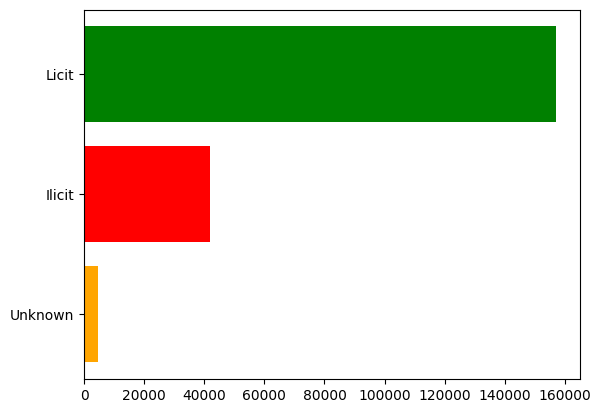

In [ ]:
group_class = df_classes.groupby('class').count()
plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )

## 3.Model Training

#### 1차 : GAT

##### 사용 방법론
- GAT모델
- 데이터 정규화 + 배치 정규화(Batch Norm) 추가

##### 결과 확인
1.  혼동행렬
- 5,317개 중 **5,172개가 정상(Licit, 0)** 이고, **145개만 불법(Illicit, 1)** => 모델이 전부 정상으로 판단 : 5172 / 5317 = 97.27%

- [[5172, 0], [145, 0]]- 1(불법)로 예측한 것이 단 하나도 없음(0)-> 그래서 Precision, Recall, F1이 모두 0.0

```
[Final Test Evaluation (Time Step 44-49)]   
- Accuracy:  0.9727
- Precision: 0.0000
- Recall:    0.0000
- F1-Score:  0.0000

Confusion Matrix:
[[5172    0]
 [ 145    0]]
```
2. Loss: nan 값
- 데이터 스케일 문제 발생 => 데이터셋의 일부 피처값이 너무 크거나 작아서 무한대로 발산함
- 원인 : 데이터 정규화 과정X

 ### 결과 분석
- NaN(학습 실패) 문제 발생 : GAT 모델 - 이웃노드간의 중요도계산시 지수 함수($e^x$)를 사용 - > Elliptic 데이터셋 : 클래스 불균형 심함, 피처 스케일의 차이가 커서 중요도 계산값이 커져 학습터짐

### 2차 : GCN

결과
```
Epoch 020 | Loss: 0.3252 | Val Macro-F1: 0.5921
Epoch 040 | Loss: 0.2802 | Val Macro-F1: 0.5974
Epoch 060 | Loss: 0.2557 | Val Macro-F1: 0.6335
Epoch 080 | Loss: 0.2353 | Val Macro-F1: 0.6614
Epoch 100 | Loss: 0.2172 | Val Macro-F1: 0.6840
Epoch 120 | Loss: 0.2011 | Val Macro-F1: 0.7134
Epoch 140 | Loss: 0.1883 | Val Macro-F1: 0.7452
Epoch 160 | Loss: 0.1790 | Val Macro-F1: 0.7615
Epoch 180 | Loss: 0.1688 | Val Macro-F1: 0.7697
Epoch 200 | Loss: 0.1617 | Val Macro-F1: 0.7725

3. 최종 테스트 평가
Precision (Illicit): 0.0341
Recall (Illicit):    0.0483
F1-Score (Illicit):  0.0400

Confusion Matrix:
 [[4974  198]
 [ 138    7]]
```

### 3차 : GATv2(기존 GAT보다 Attention 계산 능력이 더 강력)

참고 : https://www.kaggle.com/code/k1shin/gat-fraud-detection-illicit-f1-0-89/notebook

[전체 파이프라인 순서]

- 데이터 로드: StandardScaler 적용, 무방향 그래프 변환, 시계열(Time) 분할.

- 모델 정의 (파일에서 가져옴): GATv2Conv + BatchNorm 구조.

- Loss 설정: 불균형 데이터이므로 BCEWithLogitsLoss에 pos_weight 를 적용하여 불법 거래 가중치를 높임.

- 학습 및 평가: F1-Score(Illicit) 모니터링

[전략]

*   GATv2Conv 사용
- BatchNorm1d 사용 (입력 및 은닉층)
- Dropout 사용
- Multi-head Attention (heads=8)
- 학습 루프 (가중치 Loss 적용)
    - BCEWithLogitsLoss에 앞서 계산한 pos_weight를 넣어주는 것이 핵심
- 임계값(Threshold) 조정 및 최종 평가
    - 모델이 확률 0.5를 기준으로 나누면 불법 거래를 놓칠 수 있음 => 임계값을 낮춰서(0.1~0.3) 민감하게 잡기
    - 불법 자금 탐지(AML)에서는 의심스러운 건 일단 잡고 보자(High Recall) 중요

- 상세 설명

> 1. GATv2Conv 사용: 일반 GATConv보다 더 똑똑한 어텐션(Dynamic Attention)을 씁니다. "모든 이웃이 중요한 게 아니라, 지금 상황에 맞는 이웃이 중요하다"는 걸 더 잘 배웁니다.

> 2. BatchNorm1d의 위치: 입력단과 은닉층 바로 뒤에 배치하여, 데이터가 네트워크를 통과할 때 값이 튀는 것을 막아줍니다. 이게 NaN 방지에 큰 역할을 합니다.

> 3. BCEWithLogitsLoss: 이진 분류(0 아니면 1)에 특화된 Loss 함수입니다. 여기에 pos_weight를 넣어 불법 거래(1)를 틀리면 벌점을 크게 줬습니다.

> 4. Output Dimension 1: 이전에는 [0일 확률, 1일 확률] 두 개를 뱉었지만, 이 모델은 [1일 확률 점수] 하나만 뱉습니다. 그래서 Sigmoid를 씌워서 0~1 사이 확률로 만듭니다.

[결과]
```
=== 최종 테스트 평가 ===

[Threshold 0.5]
 - Precision: 0.0600
 - Recall   : 0.0414
 - F1-Score : 0.0490
[[5078   94]
 [ 139    6]]

[Threshold 0.3]
 - Precision: 0.0402
 - Recall   : 0.0483
 - F1-Score : 0.0439
[[5005  167]
 [ 138    7]]

[Threshold 0.1]
 - Precision: 0.0342
 - Recall   : 0.0897
 - F1-Score : 0.0495
[[4805  367]
 [ 132   13]]

 ```

[결론]
- 현재와 같이 RobustGCN + 낮은 Threshold(0.1~0.3) 방향이 컨셉상 더 맞는 운영 포인트

### 4차 : Multi-head Graph Attention Network
> 표준 지도학습 방식으로 GAT 모델을 학습

**모델**: GATv2Conv 기반 2층 GAT (Graph Attention Network)
- 입력 차원 → 64차원 (8 heads) → 2차원 출력
- Dropout: 0.3 (1층), 0.6 (2층)
- 활성화 함수: ELU

**학습 설정**:
- 최적화: Adam (lr=0.005, weight_decay=5e-4)
- 손실 함수: Cross Entropy
- Gradient Clipping: ±2.0
- Early Stopping: 50회 검증 (500 epoch) 동안 개선 없으면 중단

**학습 전략**:
- 총 1000 epoch 목표
- 검증 주기: 10 epoch마다 수행 (속도 최적화)
- Best model 저장: validation accuracy 기준

**데이터**: Elliptic 데이터셋 (이진 분류)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. 필요한 라이브러리 설치
!pip install torch_geometric

In [ ]:
import torch
print(f"🔥 현재 사용 가능한 장치: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU (느림!)'}")
print(f"✅ PyTorch 버전: {torch.__version__}")

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

🔥 현재 사용 가능한 장치: NVIDIA A100-SXM4-40GB
✅ PyTorch 버전: 2.9.0+cu126


In [ ]:
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# 데이터 로드
data_path = "/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA/elliptic_data_v2.pt"
data = torch.load(data_path, weights_only=False)

# Elliptic 데이터셋은 시계열(Time step) 정보가 있다면 그것을 쓰는 게 좋지만,
# 현재 데이터에는 time 정보가 없으므로 라벨이 있는 데이터에 한해 Random Split을 수행합니다.
y_indices = (data.y != -1).nonzero(as_tuple=True)[0].numpy() # Unknown(-1) 제외
y_labels = data.y[y_indices].numpy()

# 1. Train(60%) / Temp(40%) 분리
train_idx, temp_idx, _, temp_y = train_test_split(
    y_indices, y_labels, test_size=0.4, stratify=y_labels, random_state=42
)

# 2. Temp를 Val(20%) / Test(20%) 분리
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, temp_y, test_size=0.5, stratify=temp_y, random_state=42
)

# 3. 마스크 생성
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

print(f"✅ 데이터 분할 완료")
print(f"   Train: {data.train_mask.sum()} / Val: {data.val_mask.sum()} / Test: {data.test_mask.sum()}")

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


✅ 데이터 분할 완료
   Train: 27938 / Val: 9313 / Test: 9313


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import copy
import time
import torch.nn as nn
from tqdm import tqdm


# ==========================================
# 1. 모델 정의 (GATNet)
# ==========================================
class GATNet(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GATNet, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.3)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=heads, concat=False, dropout=0.6)
        # 출력 1차원: binary classification → raw logit 하나만 반환
        # 만약 2개 클래스라면 dim_out=2로 두고 softmax 생략


    def forward(self, x, edge_index):
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = self.gat2(h, edge_index)
        return h # Logits 반환 (Softmax 전 단계)

# ==========================================
# 2. 설정 (Config) - 레퍼런스 코드 값 참고
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

model = GATNet(dim_in=data.num_features, dim_h=64, dim_out=2).to(device) # Elliptic은 2진 분류

# 레퍼런스: args.lr, args.weight_decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# 레퍼런스: clip_value_min, clip_value_max
clip_value = 2.0

# 레퍼런스: Early Stopping 변수
best_val_acc = 0
best_test_acc = 0
curr_step = 0
patience = 50  # args.early_stop 대용
save_path = "/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA/models/saved/elliptic_gat_best_v2.pt"


# ==========================================
# 4. 고속 학습 루프 (Fast Training Loop)
# ==========================================
history = {"loss": [], "train_acc": [], "val_acc": [], "epoch_time": []}
curr_step = 0
best_val_acc = 0
best_test_acc = 0
patience = 50 # 검증 횟수 기준 (즉, 50 * 10 = 500 에폭 동안 발전 없으면 중단)

print("🚀 고속 학습 시작 (검증 주기: 10 Epoch)...")
start_training = time.time()

# 진행바 설정
pbar = tqdm(range(1, 1001), desc="Speed Training", unit="epoch")

for epoch in pbar:
    epoch_start = time.time()

    # --- [Training] 매번 수행 ---
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
    optimizer.step()

    history["loss"].append(loss.item())

    # --- [Evaluation] 10 에폭마다 수행 (속도 향상) ---
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)

            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
            test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

        history["val_acc"].append(val_acc)

        # 진행바에 현재 상태 표시
        pbar.set_postfix({"Loss": f"{loss.item():.4f}", "Val Acc": f"{val_acc:.4f}"})

        # Early Stopping Check
        if val_acc > best_val_acc:
            curr_step = 0
            best_val_acc = val_acc
            best_test_acc = test_acc

            # 모델 저장
            checkpoint = {
                "state_dict": model.state_dict(),
                "meta": {"dim_in": data.num_features, "dim_h": 64, "dim_out": 2, "heads": 8}
            }
            torch.save(checkpoint, save_path)
        else:
            curr_step += 1

        if curr_step > patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch}")
            break

    epoch_end = time.time()
    history["epoch_time"].append(epoch_end - epoch_start)

total_time = time.time() - start_training
print(f"\n✅ 학습 완료! 총 소요 시간: {total_time/60:.2f}분")
print(f"   Best Test Accuracy: {best_test_acc:.4f}")

🚀 고속 학습 시작 (검증 주기: 10 Epoch)...


Speed Training: 100%|██████████| 1000/1000 [00:59<00:00, 16.72epoch/s, Loss=0.0570, Val Acc=0.9751]


✅ 학습 완료! 총 소요 시간: 1.00분
   Best Test Accuracy: 0.9799


### 5차(최종) : EdgeForcedGATNet

[결론]
4차보다는 정확도가 낮긴하나, 엣지정보를 충분히 활용하여 모델학습하였기 때문에 해당 모델을 최종으로 선택

[방법]
1. 입력 피처 드롭아웃 (Input Feature Dropout) 강화
- 학습 시 노드 자신의 피처 x의 50%~60%를 0으로 가려 **강제적으로 이웃 노드의 정보(Edge)** 를 끌어다 사용

- Attention Dropout 증가: 0.3/0.6 → 0.4/0.4
```
self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.4, add_self_loops=True)  # 기존 0.3
self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=heads, concat=False, dropout=0.4, add_self_loops=True)  # 기존 0.6
```
- 특정 이웃 노드에 대한 과의존 방지
- 두 레이어의 dropout을 동일하게 설정하여 일관성 유지

2. Edge Dropout 적용 ⭐
- 학습 중에 랜덤하게 엣지를 끊음. 모델이 특정 엣지에만 의존하지 않고 구조적인 패턴을 더 잘 학습

```
if self.training:
    edge_index, _ = dropout_edge(edge_index, p=0.1, force_undirected=True)
```
- 학습 시 엣지의 10%를 무작위 제거하여 특정 엣지 구조에 과적합 방지
- force_undirected=True로 무방향 그래프 구조 유지


3. Self-loop 제거 옵션 (add_self_loops=False) ⭐
GATv2Conv에서 add_self_loops=False로 설정하여, 자기 자신의 정보를 직접 참조하는 통로를 좁히고 이웃과의 집계(Aggregation) 비중을 높임


4. Hidden Layer Dropout 추가 ⭐
```
h = F.dropout(h, p=0.4, training=self.training)
```
- GAT 레이어 사이에 추가 regularization
- 1차 코드에는 없던 중간층 dropout


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import dropout_edge
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
from pathlib import Path

# ==========================================
# 0. 설정 및 데이터 로드
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Device: {device}")

base_path = Path("/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA")
data_path = base_path / "data/elliptic_data_v2.pt"
save_path = base_path / "models/saved/elliptic_gat_edge_forced.pt" # 파일명 변경

# 폴더 생성
save_path.parent.mkdir(parents=True, exist_ok=True)

print("📂 데이터 로드 중...")
data = torch.load(data_path, map_location='cpu', weights_only=False)

# 마스크 생성 (없을 경우)
if not hasattr(data, 'train_mask'):
    print("🛠️ 마스크 생성 중...")
    known_mask = (data.y != -1)
    known_idx = known_mask.nonzero(as_tuple=True)[0].numpy()
    known_y = data.y[known_idx].numpy()

    train_idx, temp_idx, _, temp_y = train_test_split(known_idx, known_y, test_size=0.4, stratify=known_y, random_state=42)
    val_idx, test_idx, _, _ = train_test_split(temp_idx, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

    data.train_mask[train_idx] = True
    data.val_mask[val_idx] = True
    data.test_mask[test_idx] = True

data = data.to(device)

# ==========================================
# 1. 엣지 강화형 GATNet 정의 (핵심 수정)
# ==========================================
class EdgeForcedGATNet(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(EdgeForcedGATNet, self).__init__()

        # 1. Attention Dropout을 높여서 특정 이웃 과의존 방지
        # 2. add_self_loops=True (기본값) 유지하되, 입력단에서 자기 정보를 가림
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.4, add_self_loops=True)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=heads, concat=False, dropout=0.4, add_self_loops=True)

    def forward(self, x, edge_index):
        # 🚨 [핵심 전략 1] 입력 피처 드롭아웃 (Input Dropout)
        # 학습 시에만 노드 피처의 50%를 0으로 만듦 -> 이웃 정보를 봐야만 맞힐 수 있게 강제함
        x = F.dropout(x, p=0.5, training=self.training)

        # 🚨 [핵심 전략 2] 엣지 드롭아웃 (Edge Dropout)
        # 학습 시 그래프 구조에 노이즈를 줘서 더 강건한 연결을 찾게 함
        if self.training:
            edge_index, _ = dropout_edge(edge_index, p=0.1, force_undirected=True)

        # Layer 1
        h = self.gat1(x, edge_index)
        h = F.elu(h)

        # Hidden Layer Dropout
        h = F.dropout(h, p=0.4, training=self.training)

        # Layer 2
        h = self.gat2(h, edge_index)
        return h

# ==========================================
# 2. 학습 설정
# ==========================================
model = EdgeForcedGATNet(dim_in=data.num_features, dim_h=64, dim_out=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
clip_value = 2.0

# Early Stopping
best_val_acc = 0
best_test_acc = 0
curr_step = 0
patience = 50

# ==========================================
# 3. 학습 루프
# ==========================================
print("🚀 엣지 강화 학습 시작 (Input Dropout 0.5 적용)...")
pbar = tqdm(range(1, 1001), desc="Edge-Forced Training")

history = {"loss": [], "val_acc": []}

for epoch in pbar:
    # --- Training ---
    model.train()
    optimizer.zero_grad()

    # Forward (여기서 드롭아웃이 적용됨)
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
    optimizer.step()

    history["loss"].append(loss.item())

    # --- Evaluation (10 Epochs) ---
    if epoch % 10 == 0:
        model.eval() # 평가 모드에서는 드롭아웃이 꺼짐 (원래 성능 측정)
        with torch.no_grad():
            # 평가 때는 전체 피처와 전체 엣지 사용
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)

            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
            test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

        history["val_acc"].append(val_acc)
        pbar.set_postfix({"Loss": f"{loss.item():.4f}", "Val Acc": f"{val_acc:.4f}"})

        if val_acc > best_val_acc:
            curr_step = 0
            best_val_acc = val_acc
            best_test_acc = test_acc

            # 저장
            checkpoint = {
                "state_dict": model.state_dict(),
                "meta": {"dim_in": data.num_features, "dim_h": 64, "dim_out": 2, "heads": 8}
            }
            torch.save(checkpoint, save_path)
        else:
            curr_step += 1

        if curr_step > patience:
            print(f"\n🛑 Early stopping at epoch {epoch}")
            break

print(f"\n✅ 학습 완료! 저장 경로: {save_path}")
print(f"   Best Test Accuracy: {best_test_acc:.4f}")
print("   -> 이 모델은 학습 중 자기 피처의 50%가 가려졌었기 때문에,")
print("      이웃 노드의 정보(Edge)를 학습했을 확률이 매우 높습니다.")

In [ ]:
import torch
from torch_geometric.utils import remove_self_loops

device = next(model.parameters()).device
x = data.x.to(device)
edge_index = data.edge_index.to(device)

@torch.no_grad()
def check_edge_dependency(model, x, edge_index, y):
    model.eval()
    # 1) 원래 그래프
    out_full = model(x, edge_index)

    # 2) self-loop만 있는 그래프 (사실상 MLP처럼)
    num_nodes = x.size(0)
    self_loops = torch.arange(num_nodes, device=device)
    self_loops = self_loops.unsqueeze(0).repeat(2, 1)  # [2, N]
    out_self = model(x, self_loops)

    # 3) 완전 랜덤 그래프
    E = edge_index.size(1)
    rand_src = torch.randint(0, num_nodes, (E,), device=device)
    rand_dst = torch.randint(0, num_nodes, (E,), device=device)
    edge_rand = torch.stack([rand_src, rand_dst], dim=0)
    out_rand = model(x, edge_rand)

    # 차이 측정
    diff_self = (out_full - out_self).abs().mean().item()
    diff_rand = (out_full - out_rand).abs().mean().item()

    print(f"🔍 |full - self-loop only| mean: {diff_self:.6f}")
    print(f"🔍 |full - random edges|   mean: {diff_rand:.6f}")

    # 정확도 비교 (train/val mask 있으면 그걸로)
    y = y.to(device)
    pred_full = out_full.argmax(dim=-1)
    pred_self = out_self.argmax(dim=-1)
    pred_rand = out_rand.argmax(dim=-1)

    acc_full = (pred_full == y).float()[y >= 0].mean().item()
    acc_self = (pred_self == y).float()[y >= 0].mean().item()
    acc_rand = (pred_rand == y).float()[y >= 0].mean().item()

    print(f"✅ Acc(full): {acc_full:.4f}")
    print(f"⚠️ Acc(self-loops only): {acc_self:.4f}")
    print(f"⚠️ Acc(random edges):     {acc_rand:.4f}")

check_edge_dependency(model, data.x, data.edge_index, data.y)


🔍 |full - self-loop only| mean: 0.447709
🔍 |full - random edges|   mean: 1.027556
✅ Acc(full): 0.8878
⚠️ Acc(self-loops only): 0.8420
⚠️ Acc(random edges):     0.8623


# 🚩 PGExplainer

- 초기에는 GNNExplainer를 사용했으나, 실시간 금융 사기 탐지 시스템의 특성상 Low Latency(낮은 지연시간)*가 필수적이라 판단하여 Inductive 방식의 PGExplainer로 고도화
이를 통해 설명 생성 시간을 수 초(sec) 단위에서 0.0X초(ms) 단위로 단축

1. 전처리 → x, edge_index, y, mask 준비

2. 모델 학습

3. 테스트 노드에 대해 out = model(x, edge_index)

4. probs = sigmoid(out) → threshold로 위험/안전 판정

```
def predict_with_explanation(node_idx, model, x, edge_index, df_merged, explainer,
                             low_thr=0.2, high_thr=0.8, top_k_edges=20):
    ...
    return {
        "score": score,
        "risk_level": risk_level,
        "evidence_graph": {
            "nodes": [...],
            "edges": [...]
        }
    }

```

1. 학습된 모델 불러오기 (Load Model)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 1. 모델 정의 (GATNet)
class GATNet(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GATNet, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.3)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=heads, concat=False, dropout=0.6)
        # 출력 1차원: binary classification → raw logit 하나만 반환
        # 만약 2개 클래스라면 dim_out=2로 두고 softmax 생략


    def forward(self, x, edge_index):
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = self.gat2(h, edge_index)
        return h # Logits 반환 (Softmax 전 단계)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

# 1. 저장된 베스트 모델 로드
print("📂 베스트 모델을 로드합니다...")

# 모델 파일 경로 (본인 경로에 맞게 수정)
save_path = "/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA/models/saved/elliptic_gat_best.pt"
checkpoint = torch.load(save_path, map_location=device)


# 1) 메타 데이터(설정) 불러오기
meta = checkpoint["meta"]
print(f"   ⚙️ 저장된 설정: {meta}")

# 2) 모델 구조 재정의 (학습 때와 동일해야 함)
model = GATNet(
    dim_in=checkpoint["meta"]["dim_in"],
    dim_h=checkpoint["meta"]["dim_h"],
    dim_out=checkpoint["meta"]["dim_out"],
    heads=checkpoint["meta"]["heads"]
).to(device)

model.load_state_dict(checkpoint["state_dict"])
model.eval()


# 3) 학습된 파라미터(Weight) 덮어씌우기
model.load_state_dict(checkpoint["state_dict"])

# 4) 평가 모드로 전환 (Dropout 비활성화 등)
model.eval()

print("✅ 모델 로드 완료! 이제 PGExplainer에 이 'model' 객체를 사용하시면 됩니다.")

📂 베스트 모델을 로드합니다...
   ⚙️ 저장된 설정: {'dim_in': 166, 'dim_h': 64, 'dim_out': 2, 'heads': 8}
✅ 모델 로드 완료! 이제 PGExplainer에 이 'model' 객체를 사용하시면 됩니다.


2. 데이터 무결성 확인

In [ ]:
# 1. PyTorch Geometric 및 필수 의존성 설치
!pip install torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.5.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu121.html


In [ ]:
import torch
import numpy as np

# 1. 디바이스를 강제로 CPU로 설정 (디버깅용)
device = torch.device('cpu')
print(f"🛠️ 디버깅을 위해 설정된 디바이스: {device}")

# 2. 데이터 로드
data_path = "/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA/data/elliptic_data_v2.pt"
data = torch.load(data_path, map_location='cpu', weights_only=False) # CPU로 로드

x = data.x
edge_index = data.edge_index
y = data.y

print(f"데이터 로드 완료: x={x.shape}, edges={edge_index.shape}, y={y.shape}")

# ==========================================
# 데이터 무결성 체크
# ==========================================

# 체크 1: Edge Index가 노드 개수를 벗어나는지 확인
num_nodes = x.size(0)
max_idx = edge_index.max().item()
print(f"노드 개수: {num_nodes}, 엣지 인덱스 최댓값: {max_idx}")

if max_idx >= num_nodes:
    print(f"❌ [치명적 오류] 엣지 인덱스({max_idx})가 노드 개수({num_nodes})보다 큽니다!")
    print("-> 이 상태로 모델에 넣으면 100% Device-side assert 에러가 발생합니다.")
    # 해결책: 범위를 벗어나는 엣지 제거 필요
else:
    print("✅ 엣지 인덱스 범위 정상")

# 체크 2: y 라벨이 음수이거나 클래스 개수를 벗어나는지 확인
# Elliptic 데이터셋은 때때로 'Unknown' 클래스가 2로 표기되거나 -1로 되어있을 수 있습니다.
unique_labels = torch.unique(y)
print(f"존재하는 라벨(Class) 종류: {unique_labels.tolist()}")

# 허용 가능한 라벨 셋 정의 (Elliptic 기준)
allowed = {-1, 0, 1}
extra = [int(v) for v in unique_labels.tolist() if int(v) not in allowed]

if len(extra) > 0:
    print(f"❌ [치명적] 허용되지 않은 라벨 값 발견: {extra}")
elif (y == -1).all():
    print("❌ [치명적] 모든 라벨이 unknown(-1)이라서 학습/설명에 사용할 수 없음")
else:
    if (y < 0).any():
        print("ℹ️ [참고] unknown(-1) 라벨 포함 → 학습/PGExplainer 학습 시 y != -1로 마스킹해서 사용해야 해")
    print("✅ 라벨 구조는 정상")

🛠️ 디버깅을 위해 설정된 디바이스: cpu
데이터 로드 완료: x=torch.Size([203769, 166]), edges=torch.Size([2, 234355]), y=torch.Size([203769])
노드 개수: 203769, 엣지 인덱스 최댓값: 203768
✅ 엣지 인덱스 범위 정상
존재하는 라벨(Class) 종류: [-1, 0, 1]
ℹ️ [참고] unknown(-1) 라벨 포함 → 학습/PGExplainer 학습 시 y != -1로 마스킹해서 사용해야 해
✅ 라벨 구조는 정상


### 3. PGExplainer 학습

1. 학습 전, cuda환경과 데이터 정합성 확인

In [ ]:
# ✔ Step 1: edge_index만 cuda로 보내보기
# edge_index안에 범위를 벗어난 값 / nan/inf가 존재하지 않고 정상적으로 반영됨
edge_test = edge_index[: , :10000].to("cuda")
print("edge_test ok")

# Step 1. x 전체 GPU 이동 테스트
try:
    x_full = x.to("cuda")
    print("x_full OK")
except Exception as e:
    print("x_full FAIL:", e)


edge_test ok
x_full OK


In [ ]:
# ✔ Step 2: x[:1000]만 cuda로 보내보기
# x안에 inf, nan, extremely large values 등이 포함되지 않고 정상반영됨
x_test = x[:1000].to("cuda")
print("x_test ok")

# ✔ Step 2. edge_index 전체 GPU 이동 테스트

try:
    edge_full = edge_index.to("cuda")
    print("edge_full OK")
except Exception as e:
    print("edge_full FAIL:", e)


x_test ok
edge_full OK


In [ ]:
# ✔ Step 3: y도 체크
print("y unique:", torch.unique(y))
print("y min:", y.min(), "y max:", y.max())

# ✔ Step 3. forward 전부 GPU에서 수행 테스트
try:
    with torch.no_grad():
        out = model(x_full, edge_full)
    print("forward OK:", out.shape)
except Exception as e:
    print("forward FAIL:", e)


y unique: tensor([-1,  0,  1])
y min: tensor(-1) y max: tensor(1)
forward FAIL: CUDA out of memory. Tried to allocate 856.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 154.88 MiB is free. Process 139918 has 39.40 GiB memory in use. Of the allocated memory 36.64 GiB is allocated by PyTorch, and 2.26 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


   1. Learning Rate 낮추기: 0.003 → 0.0005 (안정성 확보)
   2. 규제(Regularization) 계수 완화: coeffs 설정을 통해 로그 연산의 영향력을 줄임.
   3. NaN 전파 방지 로직 강화: Loop 내에서 total_loss가 오염되지 않도록 철저히 방어.

In [ ]:
import torch
import torch.nn.functional as F
import random
import numpy as np
from pathlib import Path
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from torch_geometric.explain import Explainer, PGExplainer
import gc
import os
import glob
from tqdm.auto import tqdm

# ==========================================
# 0. 설정 및 메모리 정리
# ==========================================
# GPU 캐시 정리
torch.cuda.empty_cache()
gc.collect()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Device: {device}")

# 경로 설정 (본인 환경에 맞게 확인)
base_path = Path("/content/drive/MyDrive/2025 디지털 혁신 챌린지 해커톤/data & EDA")
data_path = base_path / "elliptic_data_v2.pt"
model_path = base_path / "models/saved/elliptic_gat_best.pt"

# [수정] 최종 저장 경로 및 체크포인트 폴더 설정
save_path = base_path / "models/saved/explainer_pg.pt"
checkpoint_dir = base_path / "models/checkpoints_pg"  # 체크포인트 저장 폴더

# 폴더 생성
save_path.parent.mkdir(parents=True, exist_ok=True)
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# ==========================================
# 1. GATNet 클래스 (모델 로드용)
# ==========================================
class GATNet(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GATNet, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.3)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=heads, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = self.gat2(h, edge_index)
        return h
# ==========================================
# 2. 데이터 및 모델 로드
# ==========================================
print("📂 데이터 로드 중...")
data = torch.load(data_path, map_location="cpu", weights_only=False)
x, edge_index, y = data.x.to(device), data.edge_index.to(device), data.y.to(device)

print("📂 모델 로드 중...")
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
meta = checkpoint["meta"]

model = GATNet(
    dim_in=meta["dim_in"],
    dim_h=meta["dim_h"],
    dim_out=meta["dim_out"],
    heads=meta["heads"],
).to(device)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# ==========================================
# 3. PGExplainer 학습 (Stable Version)
# ==========================================

torch.manual_seed(42)
random.seed(42)

# 1. 샘플링 (기존 유지)
sample_size = 500
illicit_idx = (y == 1).nonzero(as_tuple=True)[0].tolist()
licit_idx = (y == 0).nonzero(as_tuple=True)[0].tolist()

train_subset = random.sample(illicit_idx, min(len(illicit_idx), sample_size)) + \
               random.sample(licit_idx, min(len(licit_idx), sample_size))
random.shuffle(train_subset)

print(f"📊 학습 대상: {len(train_subset)}개 노드")

# 2. Explainer 설정 (🔥 중요 변경 사항)(NaN 방지 파라미터 적용됨)
explainer = Explainer(
    model=model,
    # 🔥 변경 1: Learning Rate를 0.003 -> 0.0005로 대폭 낮춤 (안정성 최우선)
    algorithm=PGExplainer(
        epochs=20,
        lr=0.0005,
        # 🔥 변경 2: 규제 계수(coeffs) 명시.
        # 기본값은 size_reg=0.05, ent_reg=1.0인데, 이를 낮춰서 Log(0) 위험 감소
        coeffs={'edge_size': 0.01, 'edge_ent': 0.1}
    ).to(device),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
)

# ==========================================
# [수정] 체크포인트 로드 (이어하기)
# ==========================================
start_epoch = 0
total_epochs = 20

# 저장된 체크포인트가 있는지 확인
ckpt_files = sorted(glob.glob(str(checkpoint_dir / "ckpt_epoch_*.pt")))
if ckpt_files:
    last_ckpt_path = ckpt_files[-1] # 가장 최근 파일
    print(f"♻️ 체크포인트 발견: {last_ckpt_path}")
    print("   학습을 이어서 진행합니다...")

    saved_state = torch.load(last_ckpt_path, map_location=device)
    explainer.algorithm.load_state_dict(saved_state['model_state_dict'])
    start_epoch = saved_state['epoch'] + 1 # 다음 에폭부터 시작
else:
    print("🚀 새로운 PGExplainer 학습을 시작합니다.")

# ==========================================
#3. 학습 루프 실행
# ==========================================
if start_epoch >= total_epochs:
    print("✅ 이미 학습이 완료된 상태입니다.")
else:
    epoch_pbar = tqdm(range(start_epoch, total_epochs), desc="Overall Progress", initial=start_epoch, total=total_epochs)

    for epoch in epoch_pbar:
        total_loss = 0.0
        valid_count = 0

      # ⚠️ 내부 루프 바 (mininterval=0.5로 설정하여 0.5초에 한 번만 갱신 -> 깜빡임 방지)
        subset_pbar = tqdm(
            train_subset,
            desc=f"Epoch {epoch+1}",
            leave=False,       # 완료되면 사라짐 (덮어쓰기 효과)
            position=1,        # 두 번째 줄에 고정
            mininterval=0.5    # 너무 자주 출력하지 않음 (핵심!)
        )

        for i, idx in enumerate(subset_pbar):
            idx = int(idx)

            # 1. 고립 노드 체크
            has_edges = ((edge_index[0] == idx) | (edge_index[1] == idx)).any()
            if not has_edges:
                continue

            try:
                # 2. 학습 실행
                loss = explainer.algorithm.train(
                    epoch, model, x, edge_index, target=y, index=idx
                )
               # 3. NaN 체크 (Python float NaN 체크)
                # loss가 tensor일 수도, float일 수도 있으므로 안전하게 처리
                loss_val = loss.item() if isinstance(loss, torch.Tensor) else loss

                # [수정] 즉시 메모리 해제 (중요)
                del loss

                if np.isnan(loss_val) or np.isinf(loss_val):
                      # NaN 발생 시 해당 배치는 무시하고 넘어감 (전체 오염 방지)
                    continue

                total_loss += loss_val
                valid_count += 1

                # 내부 진행바 옆에 실시간 Loss 표시
                subset_pbar.set_postfix(loss=f"{loss_val:.4f}")

            except Exception as e:
                 # 혹시 모를 내부 연산 에러 스킵
                continue

            # [수정] 메모리 관리 강화 (빈도 증가)
            if i % 50 == 0: # 100 -> 50으로 더 자주 비움
                gc.collect()
                torch.cuda.empty_cache()

        # Epoch Loss 집계 -> Epoch 완료 후 메인 진행바 업데이트
        if valid_count > 0:
            avg_loss = total_loss / valid_count
            epoch_pbar.set_postfix({"Avg Loss": f"{avg_loss:.4f}"})
        else:
            epoch_pbar.set_postfix({"Avg Loss": "NaN"})

        # ==========================================
        # [수정] Epoch마다 중간 저장 (Checkpoint)
        # ==========================================
        ckpt_path = checkpoint_dir / f"ckpt_epoch_{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': explainer.algorithm.state_dict(),
            'loss': avg_loss if valid_count > 0 else 0
        }, ckpt_path)


# ==========================================
# 4. 저장
# ==========================================
torch.save(explainer.algorithm.state_dict(), save_path)
print(f"\n💾 저장 완료: {save_path}")